In [72]:
import tempfile
import copy

from pyPPG import PPG, Fiducials
from pyPPG.datahandling import load_data
import pyPPG.fiducials as FP

import numpy as np
import pandas as pd
import scipy.io
import matplotlib.pyplot as plt
from scipy.signal import filtfilt, tf2zpk, freqz, cheby2, firwin
from scipy.signal import kaiserord, firwin, filtfilt, detrend, periodogram, lfilter, find_peaks, firls, resample
from dotmap import DotMap


def plot_pole_zero(b, a, title: str = 'Pole-Zero Plot') -> None:
    z, p, k = tf2zpk(b, a)

    plt.figure(figsize=(8, 8))
    plt.scatter(np.real(z), np.imag(z), marker='o', color='blue', label='Zeros')
    plt.scatter(np.real(p), np.imag(p), marker='x', color='red', label='Poles')

    plt.axhline(0, color='black', linewidth=0.5, linestyle='--')
    plt.axvline(0, color='black', linewidth=0.5, linestyle='--')

    plt.title(title)
    plt.xlabel('Real Part')
    plt.ylabel('Imaginary Part')
    plt.grid()
    plt.legend()
    plt.show()


def plot_bode(b, a, fs, title: str = 'Bode Plot') -> None:
    nyq_rate = fs/2
    w, h = freqz(b, a, worN=8000)
    #plt.plot((w/np.pi)*nyq_rate, np.log10(abs(h)), linewidth=2)

    # Magnitude plot
    plt.subplot(2, 1, 1)
    f = (w/np.pi)*nyq_rate
    plt.semilogx(f, np.log10(abs(h)), color='blue')
    plt.title(f'{title} - Magnitude Response')
    plt.xlabel('Frequency [Hz]')
    plt.ylabel('Magnitude [dB]')
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)

    # Phase plot
    plt.subplot(2, 1, 2)
    plt.semilogx(f, np.angle(h, deg=True), color='red')
    plt.title('Phase Response')
    plt.xlabel('Frequency [Hz]')
    plt.ylabel('Phase [degrees]')
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    
    # Display the plot
    plt.tight_layout()
    plt.show()

def detect_peaks(signal) -> pd.DataFrame:
    signal.vpg = np.gradient(signal.ppg)
    signal.apg = np.gradient(signal.vpg)
    signal.jpg = np.gradient(signal.apg)
    s = PPG(s=signal, check_ppg_len=True)

    corr_on = ['on', 'dn', 'dp', 'v', 'w', 'f']
    correction=pd.DataFrame()
    correction.loc[0, corr_on] = True
    signal.correction=correction

    # Extract fiducial points
    fpex = FP.FpCollection(s=s)

    # This fails:
    # fiducials = fpex.get_fiducials(s=s)
    # This is the error (I think it' because our framerate is too low):
    # ValueError                                Traceback (most recent call last)
    # Cell In[31], line 31
    #      29 ppg_fp=pd.DataFrame()
    #      30 peaks, onsets = fpex.get_peak_onset(peak_detector)
    # ---> 31 dicroticnotch = fpex.get_dicrotic_notch(peaks, onsets)
    # 
    # File ~/.cache/pypoetry/virtualenvs/heart-rate-from-camera-ByEE_clq-py3.10/lib/python3.10/site-packages/pyPPG/fiducials.py:815, in FpCollection.get_dicrotic_notch(self, peaks, onsets)
    #     813 f = [0, (FcU / Fn), (FcD / Fn), 1]          # Frequency band edges
    #     814 a = [1, 1, 0, 0]                            # Amplitudes
    # --> 815 b = firls(n, f, a)
    #     817 lp_ppg = filtfilt(b, 1,  dxx)          # Low pass filtered signal with 20 cut off Frequency and 5 Hz Transition width
    #     819 ## The weighting is calculated and applied to each beat individually
    # 
    # File ~/.cache/pypoetry/virtualenvs/heart-rate-from-camera-ByEE_clq-py3.10/lib/python3.10/site-packages/scipy/signal/_fir_filter_design.py:981, in firls(numtaps, bands, desired, weight, nyq, fs)
    #     979     raise ValueError("bands must contain frequency pairs.")
    #     980 if (bands < 0).any() or (bands > 1).any():
    # --> 981     raise ValueError("bands must be between 0 and 1 relative to Nyquist")
    #     982 bands.shape = (-1, 2)
    #     984 # check remaining params
    # 
    # ValueError: bands must be between 0 and 1 relative to Nyquist
    ######################################################
    # BEGIN REIMPLEMENTATION OF get_fiducials
    ######################################################
    self = fpex
    
    # Extract Fiducial Points
    ppg_fp=pd.DataFrame()
    peaks, onsets = fpex.get_peak_onset('PPGdet')
    
    ## The 2nd derivative and Hamming low pass filter is calculated.
    dxx = np.diff(np.diff(self.ppg))
    fs = self.fs
    
    # Make filter
    Fn = fs / 2                                 # Nyquist Frequency
    FcU = 10                                    # Cut off Frequency: MODIFIED FROM 20 Hz to 10Hz
    FcD = FcU + 5                               # Transition Frequency: 5 Hz
    
    n = 21                                      # Filter order
    f = [0, (FcU / Fn), (FcD / Fn), 1]          # Frequency band edges
    a = [1, 1, 0, 0]                            # Amplitudes
    b = firls(n, f, a)
    
    lp_ppg = filtfilt(b, 1,  dxx)          # Low pass filtered signal with 20 cut off Frequency and 5 Hz Transition width
    
    ## The weighting is calculated and applied to each beat individually
    def t_wmax(i, peaks,onsets):
        if i < 3:
            HR = np.mean(np.diff(peaks))/fs
            t_wmax = -0.1 * HR + 0.45
        else:
            t_wmax = np.mean(peaks[i - 3:i]-onsets[i - 3:i])/fs
        return t_wmax
    
    dic_not=[]
    for i in range(0,len(onsets)-1):
        nth_beat = lp_ppg[onsets[i]:onsets[i + 1]]
    
        i_Pmax=peaks[i]-onsets[i]
        t_Pmax=(peaks[i]-onsets[i])/fs
        t=np.linspace(0,len(nth_beat)-1,len(nth_beat))/fs
        T_beat=(len(nth_beat)-1)/fs
        tau=(t-t_Pmax)/(T_beat-t_Pmax)
        tau[0:i_Pmax] = 0
        beta=5
    
        if len(peaks)>1:
            t_w=t_wmax(i, peaks, onsets)
        else:
            t_w=np.NaN
    
        if t_w!=T_beat:
            tau_wmax=(t_w-t_Pmax)/(T_beat-t_Pmax)
        else:
            tau_wmax=0.9
    
        alfa=(beta*tau_wmax-2*tau_wmax+1)/(1-tau_wmax)
        if (alfa > 4.5) or (alfa < 1.5):
            HR = np.mean(np.diff(peaks))/fs
            t_w = -0.1 * HR + 0.45
            tau_wmax = (t_w - t_Pmax) / (T_beat - t_Pmax)
            alfa = (beta * tau_wmax - 2 * tau_wmax + 1) / (1 - tau_wmax)
    
        ## Calculate the Dicrotic Notch for each heart cycle using the weighted window
        if alfa>1:
            w = tau ** (alfa - 1) * (1 - tau) ** (beta - 1)
        else:
            w = tau * (1 - tau) ** (beta - 1)
    
        pp=w*nth_beat
        pp = pp[np.where(~np.isnan(pp))]
        max_pp_v = np.max(pp)
        max_pp_i=np.where(pp==max_pp_v)[0][0]
        ## NOTE!! Shifting with 26 ms. FIX IT!
        shift=int(self.fs*0.026)
        dic_not.append(max_pp_i+onsets[i]+shift)
    dicroticnotch = dic_not
    
    vpg_fp = self.get_vpg_fiducials(onsets)
    apg_fp = self.get_apg_fiducials(onsets, peaks)
    jpg_fp = self.get_jpg_fiducials(onsets, apg_fp)
    
    diastolicpeak = self.get_diastolic_peak(onsets, dicroticnotch, apg_fp.e)
    
    # Merge Fiducial Points
    keys=('on', 'sp', 'dn','dp')
    dummy = np.empty(len(peaks))
    dummy.fill(np.NaN)
    n=0
    for temp_val in (onsets,peaks,dicroticnotch,diastolicpeak):
        ppg_fp[keys[n]] = dummy
        ppg_fp[keys[n]][0:len(temp_val)]=temp_val
        n=n+1
    
    fiducials=pd.DataFrame()
    for temp_sig in (ppg_fp,vpg_fp,apg_fp,jpg_fp):
        for key in list(temp_sig.keys()):
            fiducials[key] = dummy
            temp_val = temp_sig[key].values
            fiducials[key][0:len(temp_val)]=temp_val
    
    # Correct Fiducial Points
    fiducials=self.correct_fiducials(fiducials, s.correction)
    
    fiducials=fiducials.astype('Int64')
    
    # Extract pulse offsets
    offsets = copy.deepcopy(fiducials.on[1:])
    offsets.index = offsets.index - 1
    
    # Update index name
    fiducials = fiducials.drop(len(fiducials)-1)
    fiducials = fiducials.rename_axis('Index of pulse')
    
    # Add pulse offsets
    fiducials.insert(4, 'off', offsets)
    ######################################################
    # END REIMPLEMENTATION OF get_fiducials
    ######################################################
    
    return fiducials

def plot_peaks(signal, fiducials: pd.DataFrame, title='PPG Peaks'):
    fp = Fiducials(fp=fiducials)
    signal.vpg = np.gradient(signal.ppg)
    signal.apg = np.gradient(signal.vpg)
    signal.jpg = np.gradient(signal.apg)
    s = PPG(s=signal, check_ppg_len=True)

    corr_on = ['on', 'dn', 'dp', 'v', 'w', 'f']
    correction=pd.DataFrame()
    correction.loc[0, corr_on] = True
    signal.correction=correction

    # Extract fiducial points
    fpex = FP.FpCollection(s=s)

    # This fails:
    # fiducials = fpex.get_fiducials(s=s)
    # This is the error (I think it' because our framerate is too low):
    # ValueError                                Traceback (most recent call last)
    # Cell In[31], line 31
    #      29 ppg_fp=pd.DataFrame()
    #      30 peaks, onsets = fpex.get_peak_onset(peak_detector)
    # ---> 31 dicroticnotch = fpex.get_dicrotic_notch(peaks, onsets)
    # 
    # File ~/.cache/pypoetry/virtualenvs/heart-rate-from-camera-ByEE_clq-py3.10/lib/python3.10/site-packages/pyPPG/fiducials.py:815, in FpCollection.get_dicrotic_notch(self, peaks, onsets)
    #     813 f = [0, (FcU / Fn), (FcD / Fn), 1]          # Frequency band edges
    #     814 a = [1, 1, 0, 0]                            # Amplitudes
    # --> 815 b = firls(n, f, a)
    #     817 lp_ppg = filtfilt(b, 1,  dxx)          # Low pass filtered signal with 20 cut off Frequency and 5 Hz Transition width
    #     819 ## The weighting is calculated and applied to each beat individually
    # 
    # File ~/.cache/pypoetry/virtualenvs/heart-rate-from-camera-ByEE_clq-py3.10/lib/python3.10/site-packages/scipy/signal/_fir_filter_design.py:981, in firls(numtaps, bands, desired, weight, nyq, fs)
    #     979     raise ValueError("bands must contain frequency pairs.")
    #     980 if (bands < 0).any() or (bands > 1).any():
    # --> 981     raise ValueError("bands must be between 0 and 1 relative to Nyquist")
    #     982 bands.shape = (-1, 2)
    #     984 # check remaining params
    # 
    # ValueError: bands must be between 0 and 1 relative to Nyquist
    ######################################################
    # BEGIN REIMPLEMENTATION OF get_fiducials
    ######################################################
    self = fpex
    
    # Extract Fiducial Points
    ppg_fp=pd.DataFrame()
    peaks, onsets = fpex.get_peak_onset('PPGdet')
    
    ## The 2nd derivative and Hamming low pass filter is calculated.
    dxx = np.diff(np.diff(self.ppg))
    fs = self.fs
    
    # Make filter
    Fn = fs / 2                                 # Nyquist Frequency
    FcU = 10                                    # Cut off Frequency: MODIFIED FROM 20 Hz to 10Hz
    FcD = FcU + 5                               # Transition Frequency: 5 Hz
    
    n = 21                                      # Filter order
    f = [0, (FcU / Fn), (FcD / Fn), 1]          # Frequency band edges
    a = [1, 1, 0, 0]                            # Amplitudes
    b = firls(n, f, a)
    
    lp_ppg = filtfilt(b, 1,  dxx)          # Low pass filtered signal with 20 cut off Frequency and 5 Hz Transition width
    
    ## The weighting is calculated and applied to each beat individually
    def t_wmax(i, peaks,onsets):
        if i < 3:
            HR = np.mean(np.diff(peaks))/fs
            t_wmax = -0.1 * HR + 0.45
        else:
            t_wmax = np.mean(peaks[i - 3:i]-onsets[i - 3:i])/fs
        return t_wmax
    
    dic_not=[]
    for i in range(0,len(onsets)-1):
        nth_beat = lp_ppg[onsets[i]:onsets[i + 1]]
    
        i_Pmax=peaks[i]-onsets[i]
        t_Pmax=(peaks[i]-onsets[i])/fs
        t=np.linspace(0,len(nth_beat)-1,len(nth_beat))/fs
        T_beat=(len(nth_beat)-1)/fs
        tau=(t-t_Pmax)/(T_beat-t_Pmax)
        tau[0:i_Pmax] = 0
        beta=5
    
        if len(peaks)>1:
            t_w=t_wmax(i, peaks, onsets)
        else:
            t_w=np.NaN
    
        if t_w!=T_beat:
            tau_wmax=(t_w-t_Pmax)/(T_beat-t_Pmax)
        else:
            tau_wmax=0.9
    
        alfa=(beta*tau_wmax-2*tau_wmax+1)/(1-tau_wmax)
        if (alfa > 4.5) or (alfa < 1.5):
            HR = np.mean(np.diff(peaks))/fs
            t_w = -0.1 * HR + 0.45
            tau_wmax = (t_w - t_Pmax) / (T_beat - t_Pmax)
            alfa = (beta * tau_wmax - 2 * tau_wmax + 1) / (1 - tau_wmax)
    
        ## Calculate the Dicrotic Notch for each heart cycle using the weighted window
        if alfa>1:
            w = tau ** (alfa - 1) * (1 - tau) ** (beta - 1)
        else:
            w = tau * (1 - tau) ** (beta - 1)
    
        pp=w*nth_beat
        pp = pp[np.where(~np.isnan(pp))]
        max_pp_v = np.max(pp)
        max_pp_i=np.where(pp==max_pp_v)[0][0]
        ## NOTE!! Shifting with 26 ms. FIX IT!
        shift=int(self.fs*0.026)
        dic_not.append(max_pp_i+onsets[i]+shift)
    dicroticnotch = dic_not
    
    vpg_fp = self.get_vpg_fiducials(onsets)
    apg_fp = self.get_apg_fiducials(onsets, peaks)
    jpg_fp = self.get_jpg_fiducials(onsets, apg_fp)
    
    diastolicpeak = self.get_diastolic_peak(onsets, dicroticnotch, apg_fp.e)
    
    # Merge Fiducial Points
    keys=('on', 'sp', 'dn','dp')
    dummy = np.empty(len(peaks))
    dummy.fill(np.NaN)
    n=0
    for temp_val in (onsets,peaks,dicroticnotch,diastolicpeak):
        ppg_fp[keys[n]] = dummy
        ppg_fp[keys[n]][0:len(temp_val)]=temp_val
        n=n+1
    
    fiducials=pd.DataFrame()
    for temp_sig in (ppg_fp,vpg_fp,apg_fp,jpg_fp):
        for key in list(temp_sig.keys()):
            fiducials[key] = dummy
            temp_val = temp_sig[key].values
            fiducials[key][0:len(temp_val)]=temp_val
    
    # Correct Fiducial Points
    fiducials=self.correct_fiducials(fiducials, s.correction)
    
    fiducials=fiducials.astype('Int64')
    
    # Extract pulse offsets
    offsets = copy.deepcopy(fiducials.on[1:])
    offsets.index = offsets.index - 1
    
    # Update index name
    fiducials = fiducials.drop(len(fiducials)-1)
    fiducials = fiducials.rename_axis('Index of pulse')
    
    # Add pulse offsets
    fiducials.insert(4, 'off', offsets)
    ######################################################
    # END REIMPLEMENTATION OF get_fiducials
    ######################################################
    
    fp = Fiducials(fp=fiducials)
    #print(fiducials)
    #plot_fiducials(s=s, fp=fp, savefig=savefig, show_fig=show_fig, print_flag=print_flag, use_tk=use_tk)
    # copied from https://github.com/godamartonaron/GODA_pyPPG/blob/main/pyPPG/datahandling.py#

    marker=[]
    marker_size=60
    marker = ['o', 's', 's','o', 'o', 's', 'o', 'o', 's', 'o', 's', 'o', 's', 'o', 's']
    color = ['r', 'b', 'g','m', 'r', 'b', 'g', 'r', 'b', 'g', 'm', 'c', 'k', 'r', 'b']
    fid_names = ('sp', 'on', 'dn','dp')
    str_sig = 0
    end_sig = len(s.ppg)
    len_sig=end_sig-str_sig
    step_small = 1
    if len_sig/s.fs<10:
        step_big = step_small * 1
    else:
        step_big = step_small * 5
    len_sig_sec=int(len_sig / s.fs)
    if len_sig_sec<1:
        len_sig_sec=1

    major_ticks_names = range(0,len_sig_sec,step_big)
    len_ticks_names=len(major_ticks_names)
    major_diff=len_sig/len_ticks_names
    major_ticks = np.arange(str_sig, end_sig, major_diff)
    major_ticks = major_ticks[0:len_ticks_names]
    plt.plot(s.ppg, 'k', label=None)
    for n in fid_names:
        ind = fid_names.index(n)
        plt_num = 1
        plt.subplot(111)
        plt.title(title, fontsize=20)
        ax = plt.subplot(1, 1, plt_num)
        tmp_pnt=eval("fp." + n + ".values")
        tmp_pnt=tmp_pnt[~np.isnan(tmp_pnt)].astype(int)
        tmp_sig=eval("s.ppg")
        plt.scatter(tmp_pnt, tmp_sig[tmp_pnt], s=marker_size,linewidth=2, marker = marker[ind], facecolors='none', color=color[ind], label=n)
    plt.xlabel('Time [s]', fontsize=20)
    plt.xticks(major_ticks, major_ticks_names, fontsize=20)
    plt.show()

In [90]:
type(signal)

dotmap.DotMap

In [91]:
type(filtered)

numpy.ndarray

cheby2 a = [ 1.         -1.46102034 -0.96498202  1.1530061   1.47965583 -0.70532813
 -0.82483191  0.12333209  0.20112389]
cheby2 b = [ 0.44830243 -0.18822325 -1.38828924  0.14372273  1.9690702   0.14372273
 -1.38828924 -0.18822325  0.44830243]


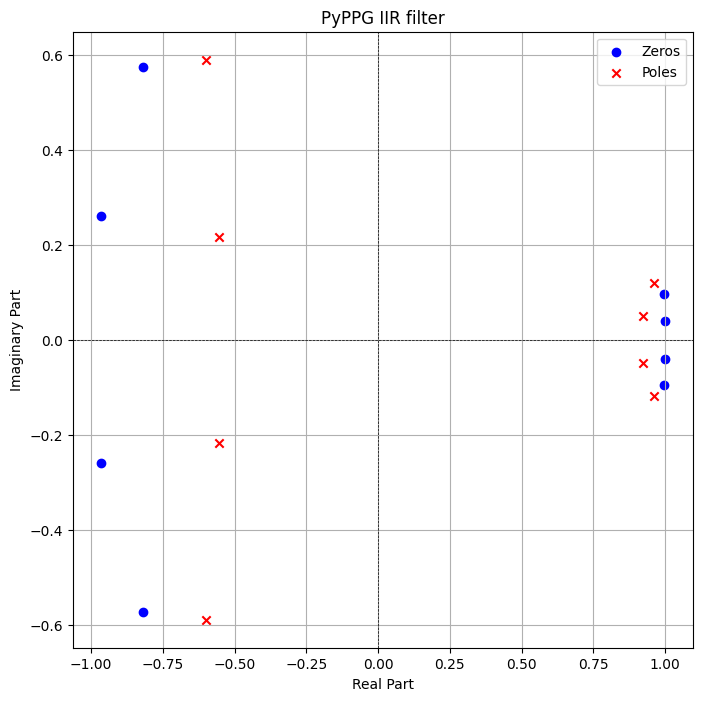

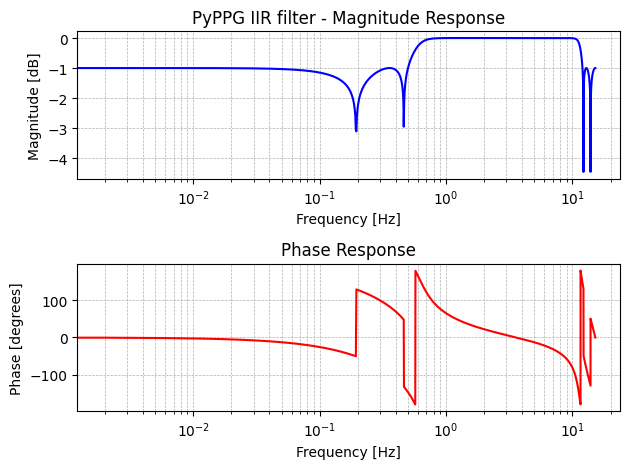

In [74]:
############################################################
# Filtering


filtered = filter_ppg(signal, verbose=False)

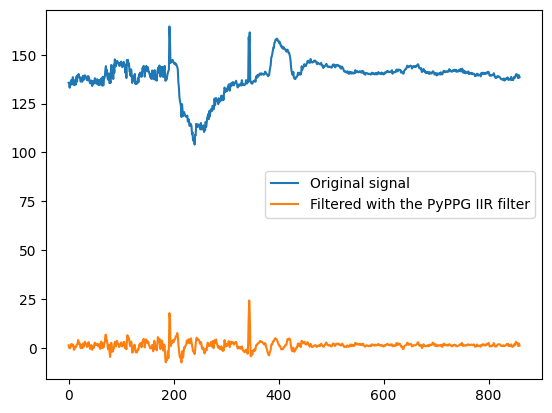

In [75]:
# Plot in time domain
points_to_plot = 2000
filtered = filtered[:points_to_plot-740]
plt.plot(signal.v[:points_to_plot], label='Original signal')
plt.plot(filtered[:points_to_plot], label='Filtered with the PyPPG')
plt.legend()
plt.show()

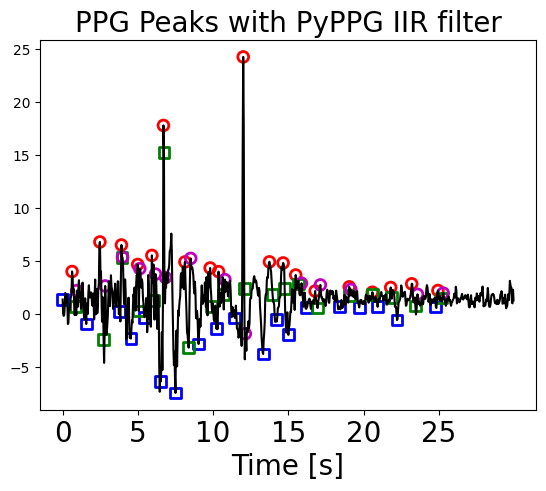

In [76]:
############################################################
# peak detection
signal.ppg = filtered
fiducials = detect_peaks(signal)
plot_peaks(signal, fiducials, 'Fiducial detection')


In [82]:
type(fiducials)

pandas.core.frame.DataFrame

In [87]:
fs

array(30.33866018)

True

In [89]:
# Take the median number of frames between two consecutive onsets
median_bpm = fiducials['on'].diff().median() * 60 / fs
median_bpm

69.21861372769065

In [81]:
fiducials['on']

Index of pulse
0       0
1      45
2     108
3     130
4     156
5     187
6     215
7     259
8     293
9     328
10    382
11    407
12    430
13    465
14    527
15    565
16    600
17    637
18    711
Name: on, dtype: Int64

In [57]:
s.fs


array(30.33866018)

In [58]:



# detect
signal.vpg = np.gradient(signal.ppg)
signal.apg = np.gradient(signal.vpg)
signal.jpg = np.gradient(signal.apg)
s = PPG(s=signal, check_ppg_len=True)



corr_on = ['on', 'dn', 'dp', 'v', 'w', 'f']
correction=pd.DataFrame()
correction.loc[0, corr_on] = True
signal.correction=correction

# Extract fiducial points
fpex = FP.FpCollection(s=s)

#fiducials = fpex.get_fiducials(s=s)


In [33]:
fpex.fs

array(30.33866018)

In [44]:
dic_not

[25,
 78,
 120,
 144,
 174,
 193,
 239,
 284,
 306,
 346,
 400,
 423,
 450,
 485,
 552,
 591,
 626,
 672,
 722]

In [30]:
len(onsets)*2

40